In [ ]:
import pyspark


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName('practice').getOrCreate()

In [ ]:
spark

In [ ]:

df_pyspark = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/test1.csv")

In [ ]:
df_pyspark

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string]

In [ ]:
df_pyspark = spark.read.option('header','true').csv('/content/drive/MyDrive/Colab Notebooks/test1.csv')

In [ ]:
df_pyspark.show(n=10)

+---+----------+-----------+----+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+----+--------+---------+---------+
| 25|       130|         80|15.0|    98.0|       86|high risk|
| 35|       140|         90|13.0|    98.0|       70|high risk|
| 29|        90|         70| 8.0|   100.0|       80|high risk|
| 30|       140|         85| 7.0|    98.0|       70|high risk|
| 35|       120|         60| 6.1|    98.0|       76| low risk|
| 23|       140|         80|7.01|    98.0|       70|high risk|
| 23|       130|         70|7.01|    98.0|       78| mid risk|
| 35|        85|         60|11.0|   102.0|       86|high risk|
| 32|       120|         90| 6.9|    98.0|       70| mid risk|
| 42|       130|         80|18.0|    98.0|       70|high risk|
+---+----------+-----------+----+--------+---------+---------+
only showing top 10 rows



In [ ]:
df_pyspark.printSchema()

root
 |-- Age: string (nullable = true)
 |-- SystolicBP: string (nullable = true)
 |-- DiastolicBP: string (nullable = true)
 |-- BS: string (nullable = true)
 |-- BodyTemp: string (nullable = true)
 |-- HeartRate: string (nullable = true)
 |-- RiskLevel: string (nullable = true)



In [ ]:
df_pyspark.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|summary|               Age|        SystolicBP|       DiastolicBP|                BS|          BodyTemp|        HeartRate|RiskLevel|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+---------+
|  count|              1218|              1218|              1218|              1218|              1218|             1218|     1218|
|   mean|30.345648604269293|114.29967159277504| 77.33251231527093| 8.996608334724584|  98.7142123750567|74.55911330049261|     NULL|
| stddev|13.354329324190482|18.671612256230894|14.052967430436778|3.4680062218030066|1.3941839952219688|8.044772201365863|     NULL|
|    min|                10|               100|               100|              10.0|             100.0|               60|high risk|
|    max|                70|                99|                95| 9.

In [ ]:
# df_pyspark= df_pyspark.groupBy(df_pyspark.columns).count().filter("count > 1").drop("count")
# df_pyspark.show()

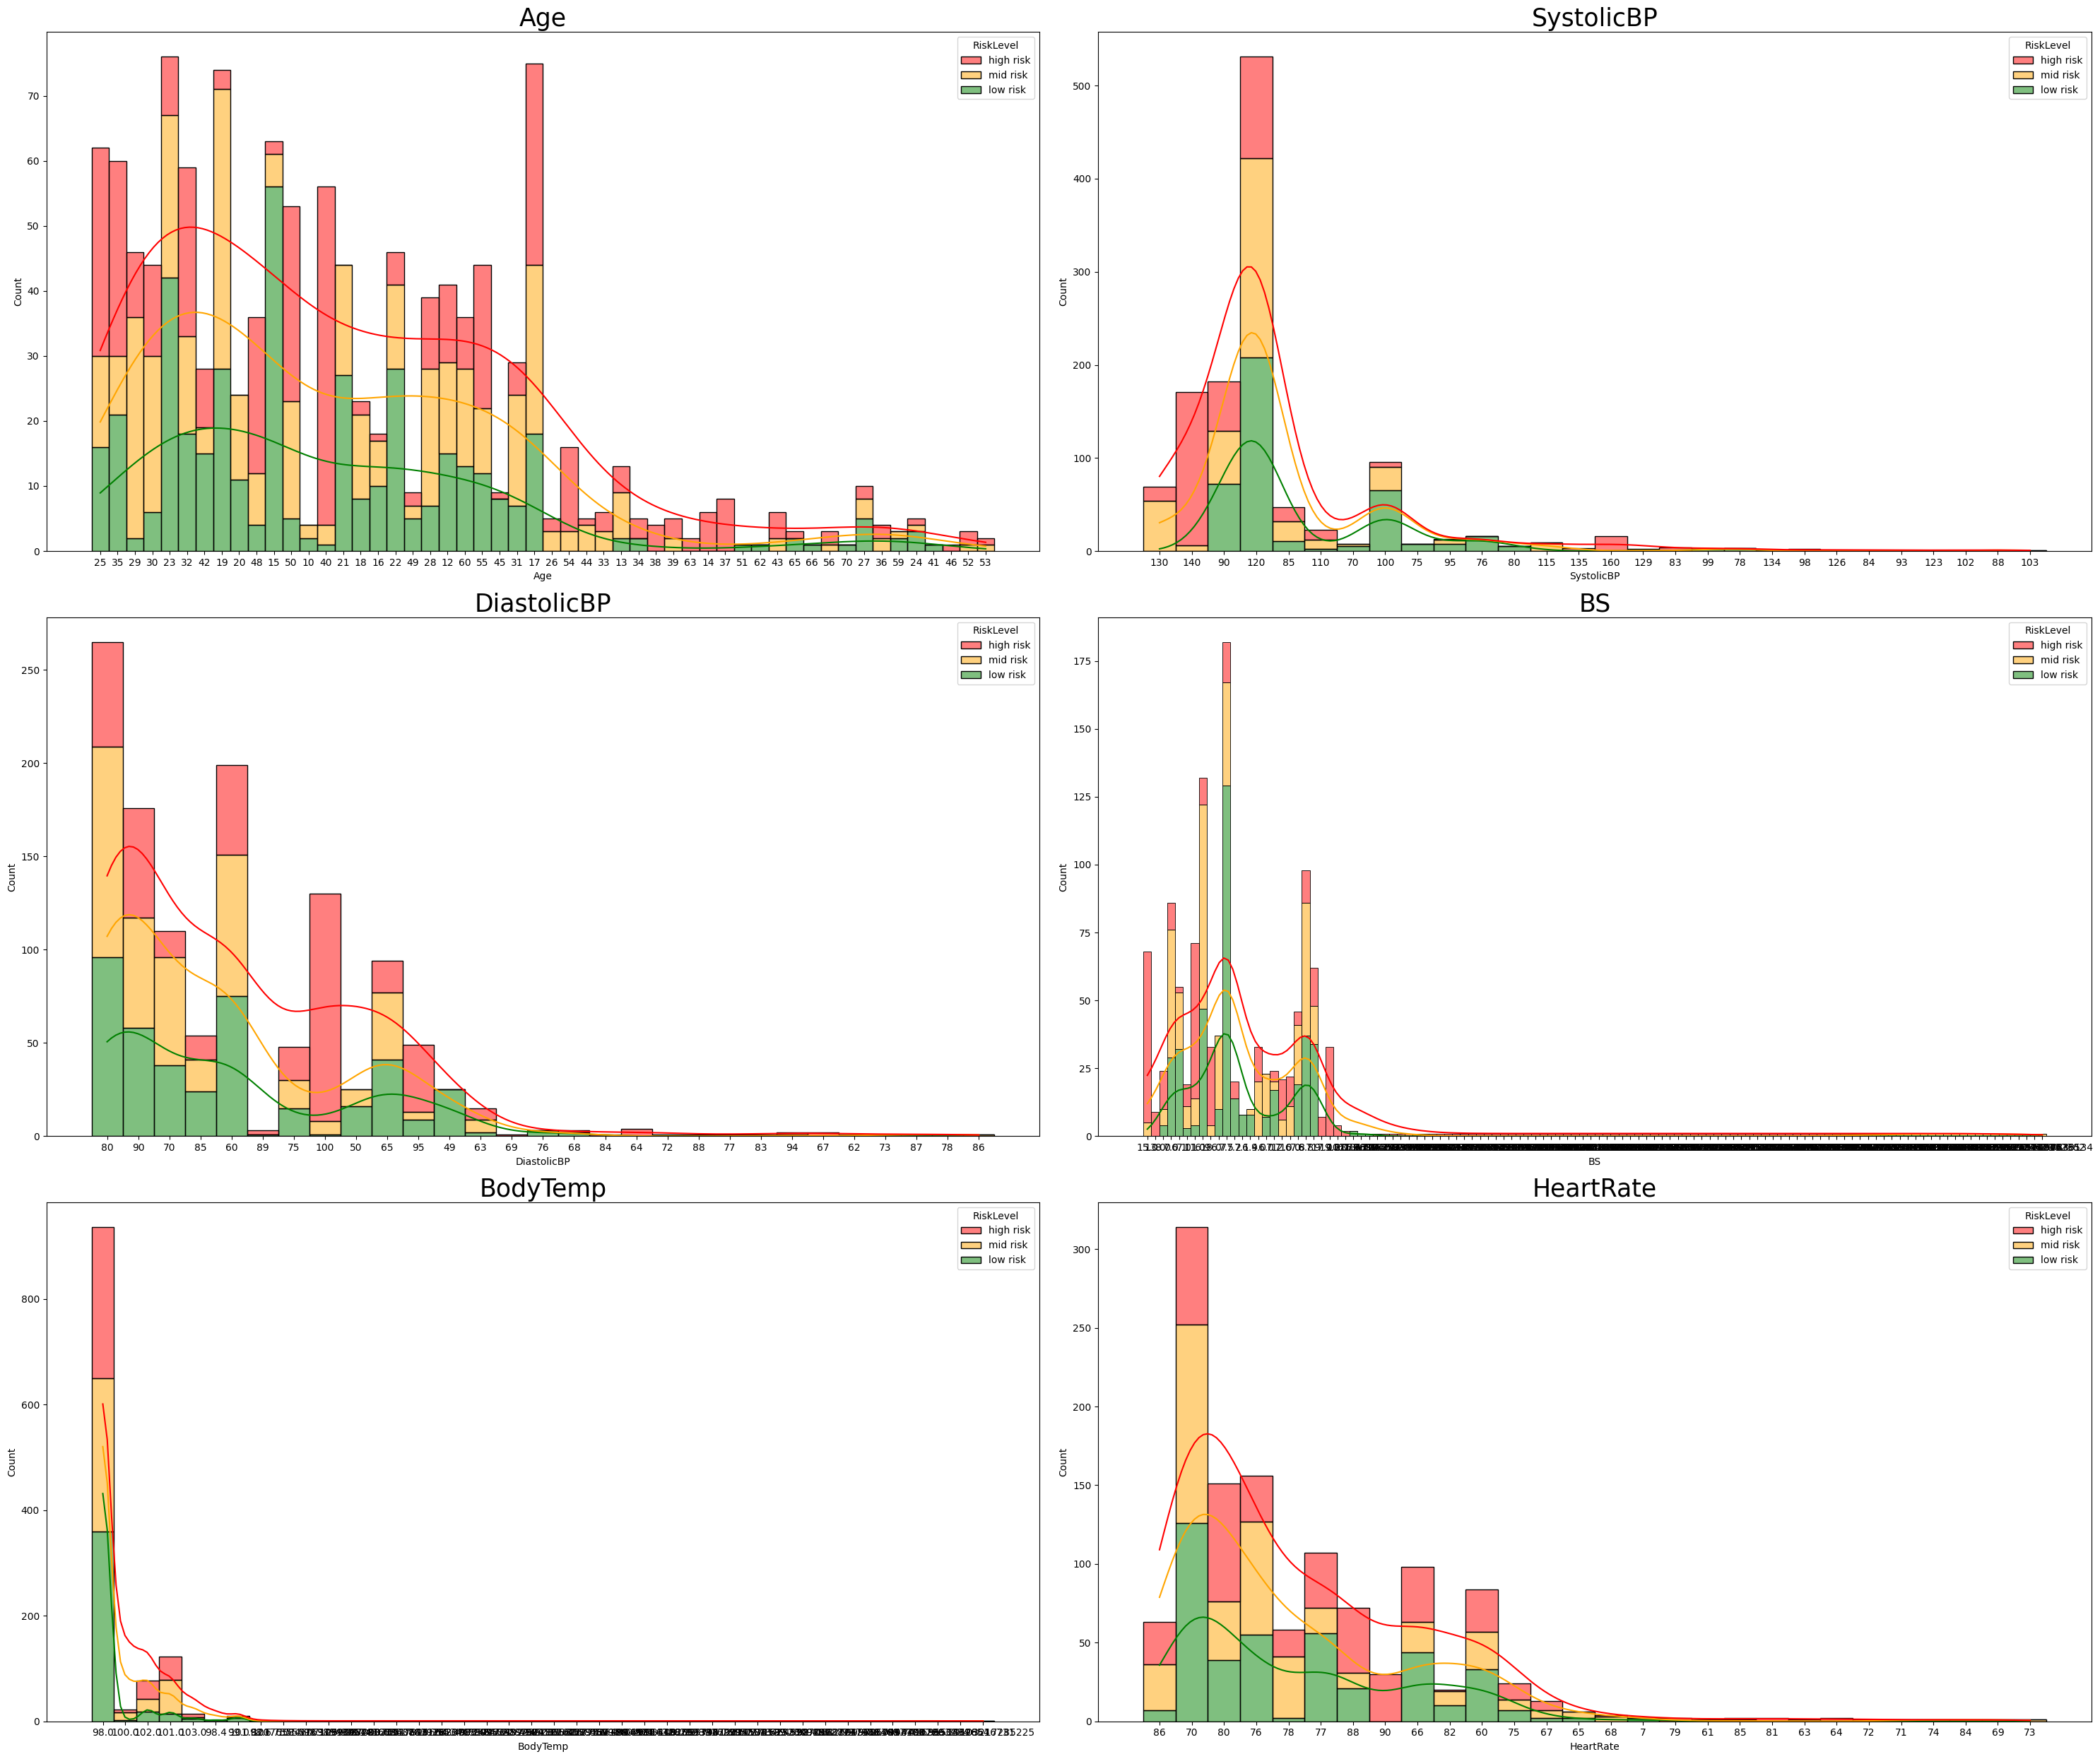

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
df_pandas = df_pyspark.toPandas()
# Plotting the histogram with KDE
# Plot stacked histograms for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 25))
risk_level_order = ["high risk", "mid risk", "low risk"]

for ax, column in zip(axes.flatten(), df_pandas.columns):
    sns.histplot(data=df_pandas,
                 x=column,
                 kde=True,
                 hue="RiskLevel",
                 hue_order=risk_level_order,
                 multiple="stack",
                 palette={"low risk": "green", "mid risk": "orange", "high risk": "red"},
                 element="bars", ax=ax)
    ax.set_title(f"{column}", fontsize=25)

plt.tight_layout()
plt.savefig("maternal_features_description.png")
plt.show()

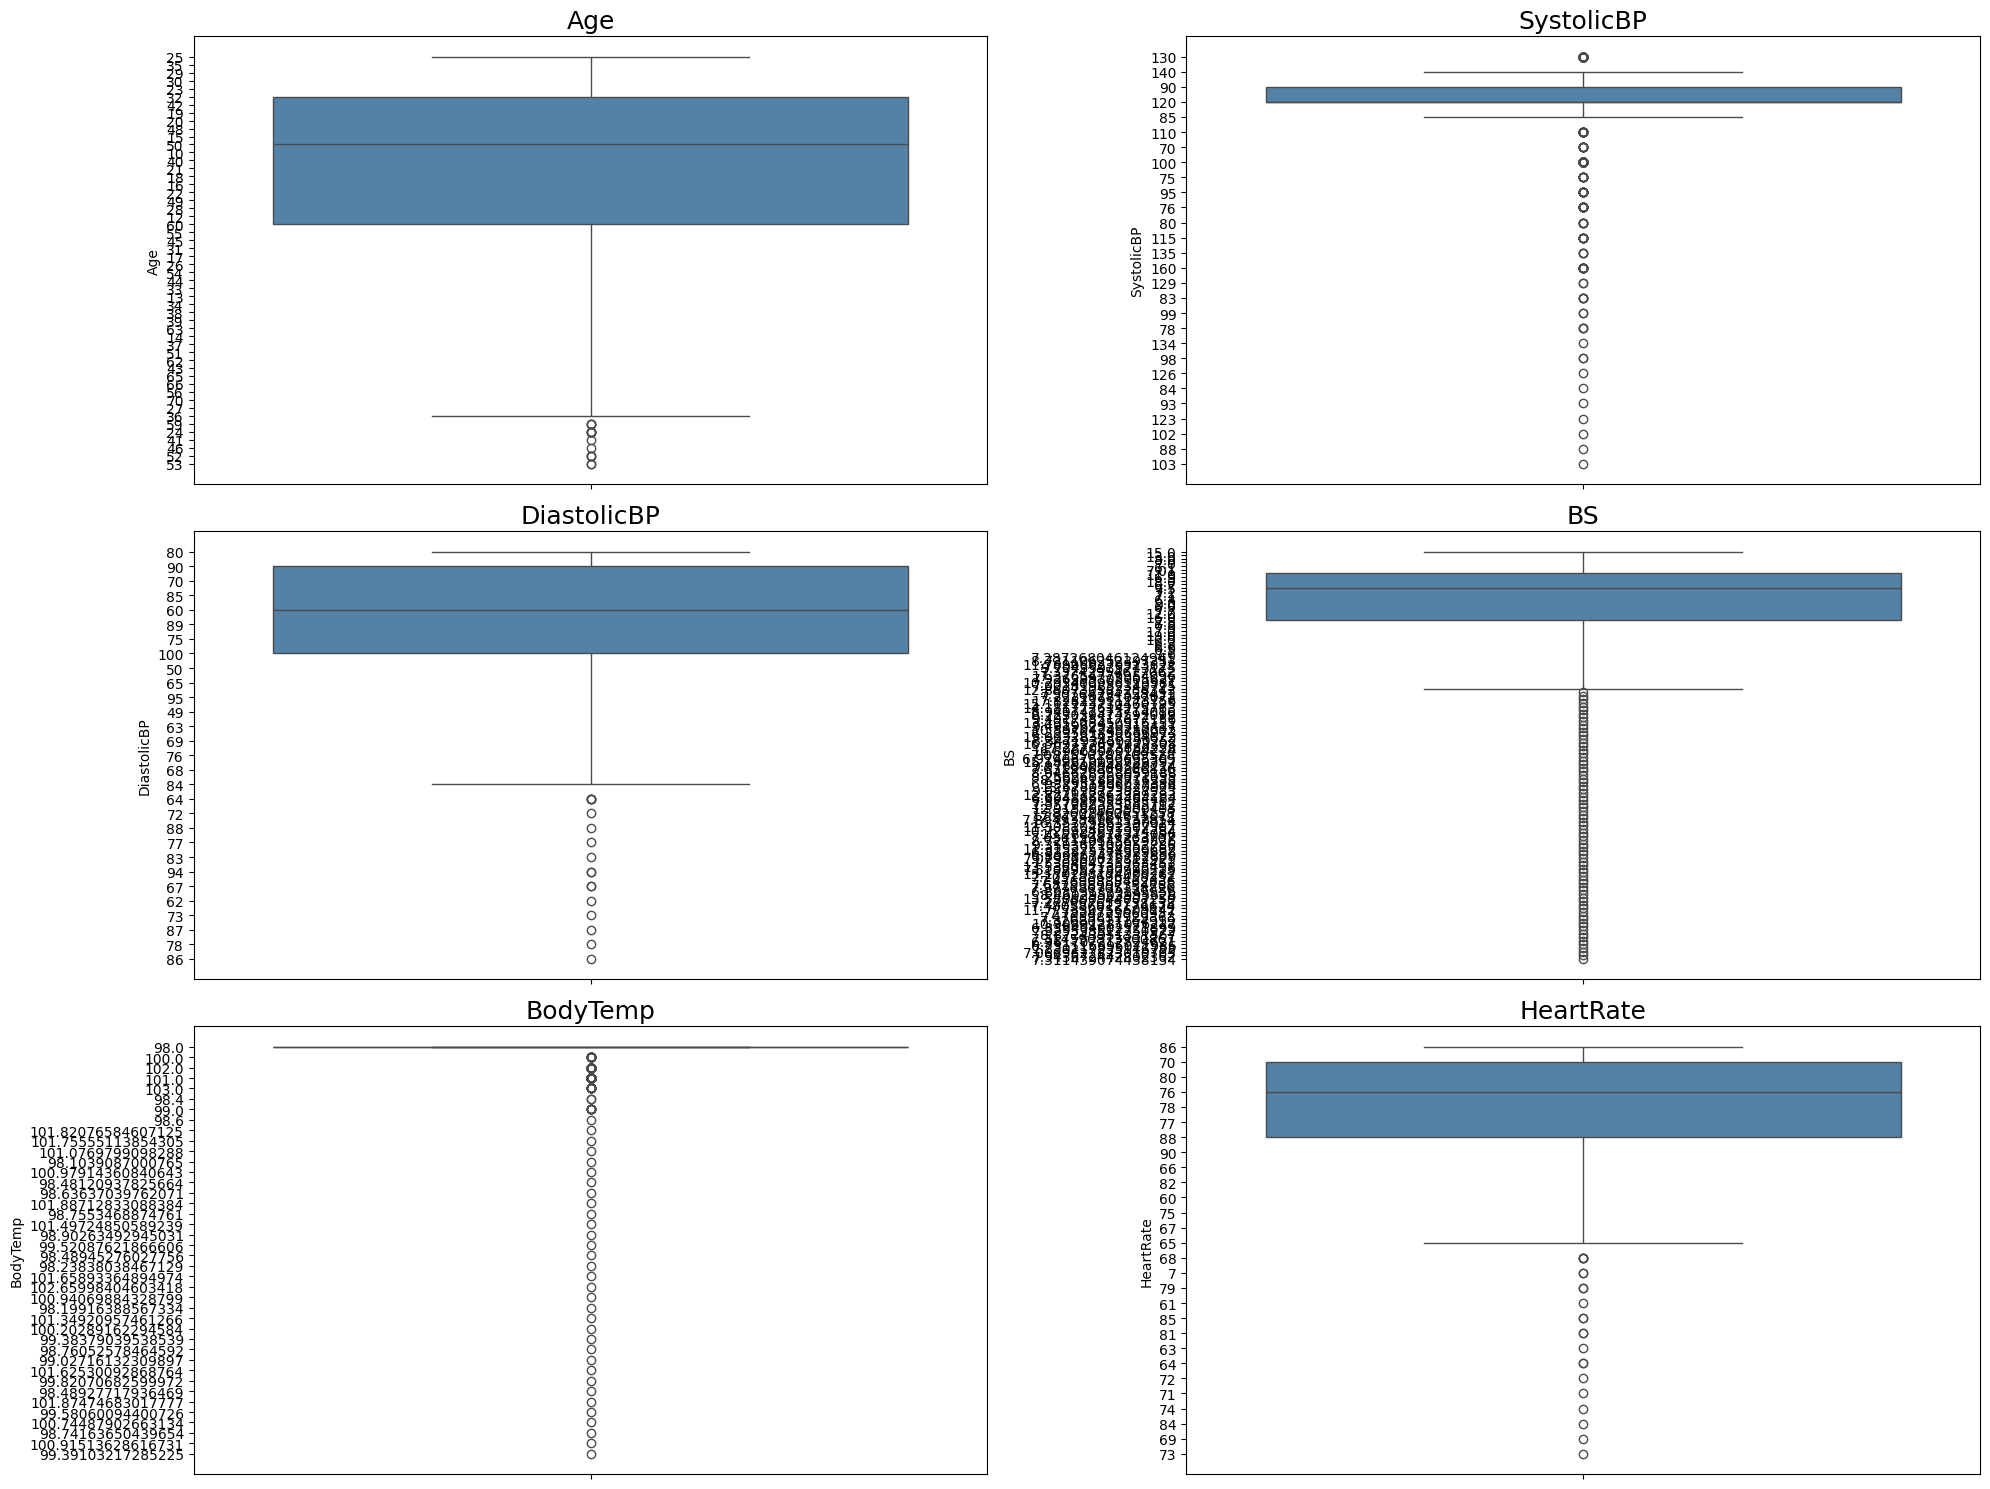

In [ ]:
# Plot boxplots for the feature variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

for ax, column in zip(axes.flatten(), df_pandas.columns):
    sns.boxplot(y=df_pandas[column],
                color="#4682B4",
                ax=ax)
    ax.set_title(f"{column}", fontsize=18)

plt.tight_layout()
plt.savefig("materanl_skewed_distribution_to_check_outliars.png")
plt.show()

In [ ]:

from pyspark.sql.functions import count, when, isnan, col

df_pyspark.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_pyspark.columns]).show()

+---+----------+-----------+---+--------+---------+---------+
|Age|SystolicBP|DiastolicBP| BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+---+--------+---------+---------+
|  0|         0|          0|  0|       0|        0|        0|
+---+----------+-----------+---+--------+---------+---------+



In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# StringIndexer to convert categorical values to numerical indices

indexer = StringIndexer(inputCol="RiskLevel", outputCol="RiskLevelIndex")
df_pyspark = indexer.fit(df_pyspark).transform(df_pyspark)

# OneHotEncoder to convert numerical indices to one-hot vectors
encoder = OneHotEncoder(inputCol="RiskLevelIndex", outputCol="RiskLevelVec")
df_pyspark = encoder.fit(df_pyspark).transform(df_pyspark)


In [ ]:
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.feature import VectorAssembler
featureassembler = VectorAssembler(inputCols=["Age","DiastolicBP",  "BS","BodyTemp","HeartRate"],outputCol="inputFeatures")


numerical_columns = ["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]
for col in numerical_columns:
    df_pyspark = df_pyspark.withColumn(col, df_pyspark[col].cast(FloatType()))
output = featureassembler.transform(df_pyspark)

In [ ]:
output.show()

+----+----------+-----------+----+--------+---------+---------+--------------+-------------+--------------------+
| Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|RiskLevelIndex| RiskLevelVec|       inputFeatures|
+----+----------+-----------+----+--------+---------+---------+--------------+-------------+--------------------+
|25.0|     130.0|       80.0|15.0|    98.0|     86.0|high risk|           0.0|(2,[0],[1.0])|[25.0,80.0,15.0,9...|
|35.0|     140.0|       90.0|13.0|    98.0|     70.0|high risk|           0.0|(2,[0],[1.0])|[35.0,90.0,13.0,9...|
|29.0|      90.0|       70.0| 8.0|   100.0|     80.0|high risk|           0.0|(2,[0],[1.0])|[29.0,70.0,8.0,10...|
|30.0|     140.0|       85.0| 7.0|    98.0|     70.0|high risk|           0.0|(2,[0],[1.0])|[30.0,85.0,7.0,98...|
|35.0|     120.0|       60.0| 6.1|    98.0|     76.0| low risk|           1.0|(2,[1],[1.0])|[35.0,60.0,6.0999...|
|23.0|     140.0|       80.0|7.01|    98.0|     70.0|high risk|           0.0|(2,[0],[1.

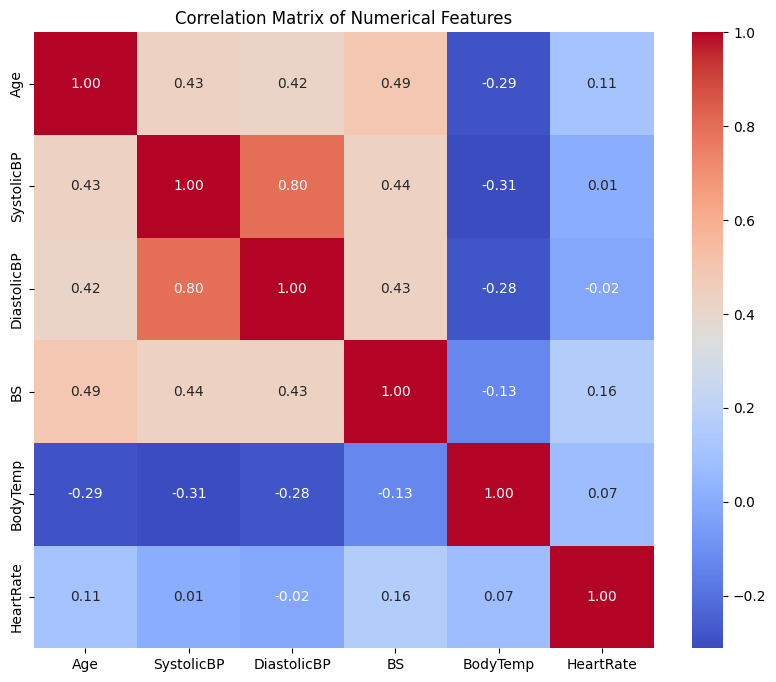

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns


pandas_df = output.select(numerical_columns).toPandas()

# Calculate the correlation matrix
correlation_matrix = pandas_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming pandas_df is your original DataFrame
X = pandas_df[["SystolicBP", "DiastolicBP"]]  # Select the predictors

# Initialize an empty DataFrame to store the results
vif_data = pd.DataFrame()

# Add the variable names (columns of X) to the DataFrame
vif_data["Variable"] = X.columns

# Calculate the VIF for each variable
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the results
print(vif_data)


      Variable        VIF
0   SystolicBP  84.601085
1  DiastolicBP  84.601098


In [ ]:
df_pyspark = output.select(['inputFeatures','RiskLevelIndex'])
df_pyspark.show()

+--------------------+--------------+
|       inputFeatures|RiskLevelIndex|
+--------------------+--------------+
|[25.0,80.0,15.0,9...|           0.0|
|[35.0,90.0,13.0,9...|           0.0|
|[29.0,70.0,8.0,10...|           0.0|
|[30.0,85.0,7.0,98...|           0.0|
|[35.0,60.0,6.0999...|           1.0|
|[23.0,80.0,7.0100...|           0.0|
|[23.0,70.0,7.0100...|           2.0|
|[35.0,60.0,11.0,1...|           0.0|
|[32.0,90.0,6.9000...|           2.0|
|[42.0,80.0,18.0,9...|           0.0|
|[23.0,60.0,7.0100...|           1.0|
|[19.0,80.0,7.0,98...|           2.0|
|[25.0,89.0,7.0100...|           1.0|
|[20.0,75.0,7.0100...|           2.0|
|[48.0,80.0,11.0,9...|           2.0|
|[15.0,80.0,7.0100...|           1.0|
|[50.0,90.0,15.0,9...|           0.0|
|[25.0,100.0,7.010...|           0.0|
|[30.0,80.0,6.9000...|           2.0|
|[10.0,50.0,6.9000...|           1.0|
+--------------------+--------------+
only showing top 20 rows



In [ ]:

from pyspark.ml.feature import StandardScaler
train_data, test_data = df_pyspark.randomSplit([0.8, 0.2], seed=42)
scaler = StandardScaler(inputCol="inputFeatures", outputCol="scaledFeatures")
scaler_model = scaler.fit(train_data)
train_data = scaler_model.transform(train_data)

test_data = scaler_model.transform(test_data)

print(f"Training set count: {train_data.count()}")
print(f"Testing set count: {test_data.count()}")

Training set count: 1008
Testing set count: 210


In [ ]:
train_data.show()

+--------------------+--------------+--------------------+
|       inputFeatures|RiskLevelIndex|      scaledFeatures|
+--------------------+--------------+--------------------+
|[10.0,50.0,6.0,99...|           2.0|[0.75368670952672...|
|[10.0,50.0,6.0,99...|           2.0|[0.75368670952672...|
|[10.0,65.0,6.9000...|           1.0|[0.75368670952672...|
|[12.0,50.0,6.0,98...|           2.0|[0.90442405143206...|
|[12.0,50.0,6.0,98...|           2.0|[0.90442405143206...|
|[12.0,50.0,6.4000...|           2.0|[0.90442405143206...|
|[12.0,60.0,6.0999...|           1.0|[0.90442405143206...|
|[12.0,60.0,6.6999...|           1.0|[0.90442405143206...|
|[12.0,60.0,6.9000...|           1.0|[0.90442405143206...|
|[12.0,60.0,6.9000...|           2.0|[0.90442405143206...|
|[12.0,60.0,6.9000...|           2.0|[0.90442405143206...|
|[12.0,60.0,6.9000...|           2.0|[0.90442405143206...|
|[12.0,60.0,6.9000...|           1.0|[0.90442405143206...|
|[12.0,60.0,7.1999...|           1.0|[0.90442405143206..

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Logistic Regression Model
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="RiskLevelIndex", maxIter=10)

# Fit the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Show predictions
predictions.select("scaledFeatures", "RiskLevelIndex", "prediction", "probability").show()


+--------------------+--------------+----------+--------------------+
|      scaledFeatures|RiskLevelIndex|prediction|         probability|
+--------------------+--------------+----------+--------------------+
|[0.75368670952672...|           1.0|       1.0|[0.01327301515018...|
|[0.90442405143206...|           2.0|       1.0|[0.00945951367506...|
|[0.90442405143206...|           1.0|       2.0|[0.09387691882560...|
|[0.90442405143206...|           2.0|       1.0|[0.02107633581590...|
|[0.90442405143206...|           1.0|       1.0|[0.03023909264871...|
|[0.90442405143206...|           1.0|       2.0|[0.22287926970696...|
|[0.90442405143206...|           0.0|       2.0|[0.26109147131497...|
|[0.90442405143206...|           0.0|       0.0|[0.56615374592124...|
|[0.97979272238474...|           0.0|       2.0|[0.36002927624641...|
|[0.97979272238474...|           0.0|       2.0|[0.30303787589714...|
|[0.97979272238474...|           1.0|       2.0|[0.30303787589714...|
|[0.97979272238474..

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="RiskLevelIndex",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.6142857142857143


In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(
    labelCol="RiskLevelIndex",  # The target column
    featuresCol="scaledFeatures",  # The features vector column
    numTrees=1000,  # Number of trees in the forest
    seed=42
)

# Fit the model to the training data
rf_model = rf.fit(train_data)

# Make predictions on the test data
predictions = rf_model.transform(test_data)


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="RiskLevelIndex",  # Target column
    predictionCol="prediction",  # Predicted column
    metricName="accuracy"  # You can also use "f1", "precision", or "recall"
)

# Calculate accuracy
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.74


In [ ]:
# prompt: create ANN and fit the model

# Assuming 'train_data' and 'test_data' are already defined and preprocessed as in the provided code.
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the layers for the neural network
feature_size = len(train_data.select("scaledFeatures").first()[0])  # ✅ Extract feature count properly
layers = [feature_size, 10, 5, 3]
# Create the MultilayerPerceptronClassifier
ann = MultilayerPerceptronClassifier(
    featuresCol="scaledFeatures",
    labelCol="RiskLevelIndex",
    maxIter=10000,  # Number of iterations
    layers=layers,
    blockSize=128,  # Size of mini-batches
    seed=1234  # Random seed
)

# Train the model
ann_model = ann.fit(train_data)

# Make predictions on the test data
predictions = ann_model.transform(test_data)

# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="RiskLevelIndex",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"ANN Test Accuracy: {accuracy}")

predictions.select("scaledFeatures", "RiskLevelIndex", "prediction", "probability").show()


ANN Test Accuracy: 0.6190476190476191
+--------------------+--------------+----------+--------------------+
|      scaledFeatures|RiskLevelIndex|prediction|         probability|
+--------------------+--------------+----------+--------------------+
|[0.75368670952672...|           1.0|       1.0|[0.11404897911722...|
|[0.90442405143206...|           2.0|       1.0|[0.11404897911569...|
|[0.90442405143206...|           1.0|       1.0|[0.11404897875182...|
|[0.90442405143206...|           2.0|       1.0|[0.11404897932010...|
|[0.90442405143206...|           1.0|       1.0|[0.11404897919134...|
|[0.90442405143206...|           1.0|       1.0|[0.11404897870096...|
|[0.90442405143206...|           0.0|       1.0|[0.11404897867203...|
|[0.90442405143206...|           0.0|       0.0|[0.74034420311661...|
|[0.97979272238474...|           0.0|       1.0|[0.11404897892773...|
|[0.97979272238474...|           0.0|       1.0|[0.11404897915188...|
|[0.97979272238474...|           1.0|       1.0|[0.1